        plate region_code region_code_letters
0   X059CP797         797                 X05
1   Y800MH790         790                 Y80
2    A212TX77          77                 A21
3   P001AY199         199                 P00
4   P001AY199         199                 P00
5   B400BB750         750                 B40
6   P666OM790         790                 P66
7   C080KP777         777                 C08
8   E737AY550         550                 E73
9   C001KK750         750                 C00
10   P227YC77          77                 P22
11  A111HA777         777                 A11
12  P745CX797         797                 P74
13  Y100CP777         777                 Y10
14  T047EM797         797                 T04
15   P991CC05          05                 P99
16   P141BY77          77                 P14
17   X140YM38          38                 X14
18  C400OP797         797                 C40
19   Y999HM34          34                 Y99
        plate region_code region_c

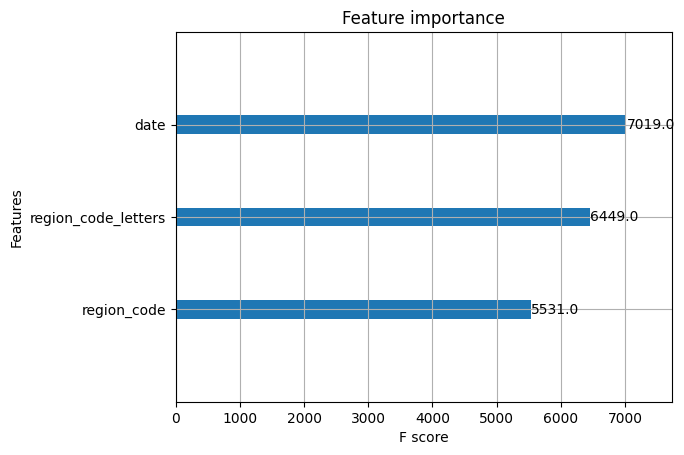

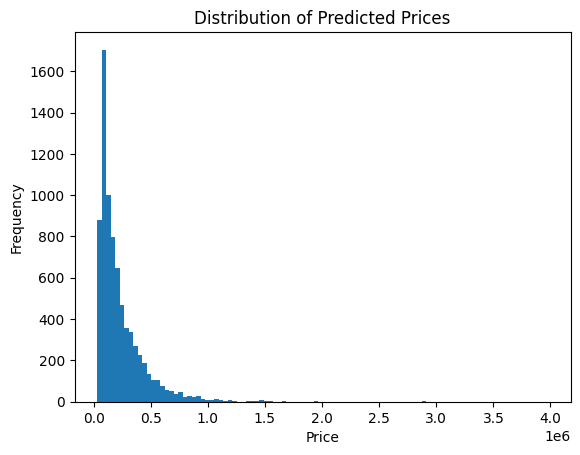

In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

####LOAD TRAINING, TEST DATA AND SUPPLI DATA
train_data = pd.read_csv("/Users/dhanalakshmijothi/Desktop/Kaggle/russian-car-plates-prices-prediction/train.csv")
test_data = pd.read_csv("/Users/dhanalakshmijothi/Desktop/Kaggle/russian-car-plates-prices-prediction/test.csv")
with open('/Users/dhanalakshmijothi/Desktop/Kaggle/russian-car-plates-prices-prediction/supplemental_english.py') as file:
    supple_data = file.read()
exec(supple_data)

### DATA MANIPULATION

# Extract region code from the plate
train_data['region_code'] = train_data['plate'].str[6:]
train_data['region_code_letters'] = train_data['plate'].str[:3]
test_data['region_code'] = test_data['plate'].str[6:]
test_data['region_code_letters'] = test_data['plate'].str[:3]

print(train_data[['plate', 'region_code', 'region_code_letters']].head(20))
print(test_data[['plate', 'region_code', 'region_code_letters']].head(20))

# Label encoding for region_code and region_code_letters
label_encoder = LabelEncoder()
train_data['region_code'] = label_encoder.fit_transform(train_data['region_code'])
test_data['region_code'] = label_encoder.transform(test_data['region_code'])

train_data['region_code_letters'] = label_encoder.fit_transform(train_data['region_code_letters'])
test_data['region_code_letters'] = label_encoder.transform(test_data['region_code_letters'])

# Log transform target variable to handle skew
train_data['log_price'] = np.log1p(train_data['price'])

#train_data['category'] = label_encoder.fit_transform(train_data['category'])
#test_data['category'] = label_encoder.transform(test_data['category'])

# Convert date to ordinal (numeric format)
train_data['date'] = pd.to_datetime(train_data['date']).map(lambda x: x.toordinal())
test_data['date'] = pd.to_datetime(test_data['date']).map(lambda x: x.toordinal())

# Prepare feature and target variable
x_train = train_data.drop(columns=['id', 'plate', 'price', 'log_price'])
y_train = train_data['log_price']
x_test = test_data.drop(columns=['id', 'plate', 'price'])

# Define the XGBRegressor model
model = xgb.XGBRegressor(objective='reg:squarederror', enable_categorical=True)

# Define the hyperparameter grid to search
param_grid = {
    'max_depth': [3, 5, 7],  # Depth of each tree
    'learning_rate': [0.01, 0.1],  # Step size shrinkage
    'n_estimators': [50, 100, 200],  # Number of boosting rounds
    'subsample': [0.7, 1.0],  # Fraction of samples to train each tree
    'colsample_bytree': [0.7, 1.0],  # Fraction of features to train each tree
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition
    'reg_lambda': [0, 1],  # L2 regularization term
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Fit the model with grid search
grid_search.fit(x_train, y_train)

# Get the best hyperparameters from grid search
print(f"Best hyperparameters found: {grid_search.best_params_}")

# Best model from grid search
best_model = grid_search.best_estimator_

# Make predictions on the test data
y_pred_log = best_model.predict(x_test)
y_pred = np.expm1(y_pred_log)

# Optionally, you can plot the feature importance from the best model
xgb.plot_importance(best_model)
plt.show()

# Prepare the submission file
submission = pd.DataFrame({
    'id': test_data['id'],
    'price': y_pred
})

submission.to_csv('/Users/dhanalakshmijothi/Desktop/Kaggle/russian-car-plates-prices-prediction/submission.csv', index=False)

# Check the distribution of the predicted prices
plt.hist(submission['price'], bins=100)
plt.title("Distribution of Predicted Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()
